In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras import backend as K
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
import keras.regularizers
from tensorflow.keras import optimizers

In [95]:
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [96]:
def plot_loss(model):
    # Plot the training loss.
    plt.plot(history.history['loss'], 'r-')

    # Plot the validation loss.
    plt.plot(history.history['val_loss'], 'b-')

    # X-axis label.
    plt.xlabel('Epochs')

    # Y-axis label.
    plt.ylabel('Cost')

    # Graph legend.
    plt.legend(["Training loss", "Validation loss"])

    # Graph title.
    plt.title('Loss Graph')

    plt.show()

In [97]:
class DiabetesPredictor:
    def __init__(self, *args, **kwargs):
        """DiabetesPredictor

    This is a class contains the most part of the methods needed for the diabetes predictor,
    first get the data of the csv file and then perform some methods to clean the data insid
    and allows you to choose if it has to replace outliers or not and replace nulls values or not.


    Attributes:
        replace_outliers: Use the string "replace_outliers" if you want to do that on your model with the median value
        replace_nulls: Use the string "replace_nulls" to replace all nulls in your model with the median value
        delete_row_with_outliers: Use the string "delete_row_with_outliers" to replace all the rows that contains outliers
    """
        self.df = pd.read_csv('diabetes.csv')
        if("replace_outliers" in args):
            self.replace_outliers()
        if("replace_nulls" in args):
            self.replace_nulls()
        if("delete_row_with_outliers" in args):
            self.delete_row_with_outliers()
        if("delete_row_with_nulls" in args):
            self.delete_row_with_nulls()
        self.separate_data_and_labels()
        self.normalize_data()
        self.split_train_test()
        self.find_best_hyperparams()
        self.train_model(25)
        self.make_predictions()
        self.plot_roc()
        self.get_metrics()
        
    def separate_data_and_labels(self):
        df_values = self.df.values
        self.x = df_values[:,:-1]
        self.y = df_values[:, -1].reshape(self.x.shape[0], 1)

    def get_correlation(self):
        correlations = self.df.corr()
        return correlations['Outcome'].sort_values(ascending=False)
    
    def replace_outliers(self):
        #Para cada columna (excepto para el Outcome) se reemplazan los outliers por su mediana.
        for col in self.df.columns:
            if (col!= "Outcome"):
                #Cálculo de parámetros para obtener los outliers.
                q1 = self.df[col].quantile(0.25)
                q3 = self.df[col].quantile(0.75)
                iqr = q3-q1
                #Límites de los valores tipicos.
                Lower_tail = q1 - 1.5 * iqr
                Upper_tail = q3 + 1.5 * iqr
                #Cálculo de la mediana.
                med = np.median(self.df[col])
                #Reemplazo.
                for i in self.df[col]:
                    if i > Upper_tail or i < Lower_tail:
                            self.df[col] = self.df[col].replace(i, med)

    def replace_nulls(self):
        columns = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
        self.df[columns] = self.df[columns].replace(0,np.NaN)
        median=self.df[columns].median()
        self.df[columns]=self.df[columns].replace(np.NaN,median)

    def remove_cols(self, cols):
        self.df = self.df.drop(['SkinThickness', 'BloodPressure'], axis=1)
    
    def normalize_data(self):
        # Mean, columnar axis.
        x_mean = np.mean(self.x, axis=0, keepdims=True)
        # Std. Deviation, columnar axis.
        x_std = np.std(self.x, axis=0, keepdims=True)
        # Normalizing.
        self.x = (self.x - x_mean)/x_std

    def split_train_test(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.1, random_state=5)

    def model_builder(self,hp):
        model = Sequential()
        model.add(Dense(1,activation='sigmoid', input_shape=(self.x.shape[1],)))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_learning_rate = hp.Choice('learning_rate', values=[1.0, 0.1, 1e-2, 1e-3, 1e-4, 1e-5])
        

        model.compile(optimizer=optimizers.SGD(momentum=hp_momentum, learning_rate=hp_learning_rate, ),
                        loss=keras.losses.BinaryCrossentropy(from_logits=True),
                        metrics=[tf.keras.metrics.AUC()])

        return model

    def find_best_hyperparams(self):
        self.tuner = kt.Hyperband(self.model_builder,
                     kt.Objective("val_loss", direction="min"),
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='redes_tp2_ej1')
        self.tuner.search(self.x_train, self.y_train, epochs=50, validation_split=0.2)
        self.best_hps=self.tuner.get_best_hyperparameters(num_trials=2)[0]

    def train_model(self, epochs):
        model = self.tuner.hypermodel.build(self.best_hps)
        history = model.fit(self.x_train, self.y_train, epochs=50, validation_split=0.2)

        val_acc_per_epoch = history.history['val_loss']
        best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
        print('Best epoch: %d' % (best_epoch,))
        #plot_loss(history)
        self.hypermodel = self.tuner.hypermodel.build(self.best_hps)

        # Retrain the model
        self.hypermodel.fit(self.x_train, self.y_train, epochs=25, validation_split=0.2)

    def make_predictions(self):
        preds = self.hypermodel.predict(self.x_test)
        self.predictions = np.rint(preds)

    def plot_roc(self):
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(self.y_test, self.predictions)
        auc_keras = auc(fpr_keras, tpr_keras)
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()

    def get_metrics(self):
        print('Specificity: ' + str(specificity(self.y_test.astype(float), self.predictions.astype(float))))
        print('Sensitivity: ' + str(sensitivity(self.y_test.astype(float), self.predictions.astype(float))))
        print('Positive Predictive Value: ' + str(positive_predictive_value(self.y_test.astype(float), self.predictions.astype(float))))
        print('Negative Predictive Value: ' + str(negative_predictive_value(self.y_test.astype(float), self.predictions.astype(float))))
    
    def delete_row_with_outliers(self):
        #Para cada columna (excepto para el Outcome) se buscan los outliers para borrar la fila
        for col in self.df.columns:
            if (col!= "Outcome"):
                #Cálculo de parámetros para obtener los outliers.
                q1 = self.df[col].quantile(0.25)
                q3 = self.df[col].quantile(0.75)
                iqr = q3-q1
                #Límites de los valores tipicos.
                Lower_tail = q1 - 1.5 * iqr
                Upper_tail = q3 + 1.5 * iqr
                #Cálculo de la mediana.
                med = np.median(self.df[col])
                #Reemplazo.
                for i in self.df[col]:
                    if i > Upper_tail or i < Lower_tail:
                            self.df = self.df[self.df.col != i]

    def delete_row_with_nulls(self):
        """Complete"""

INFO:tensorflow:Reloading Oracle from existing project my_dir\redes_tp2_ej1\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\redes_tp2_ej1\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
c:\Users\Usuario\Documents\ITBA\2021 1er cuatrimestre\Redes Neuronales\TPs\TP2\DeepLearning_Project2\env\lib\site-packages\keras\backend.py:4981: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
18/18 [==============================] - 1s 22ms/step - loss: 0.5730 - auc: 0.7825 - val_loss: 0.4885 - val_auc: 0.8271
Epoch 2/50
18/18 [==============================] - 0s 3ms/step - loss: 0.4924 - auc: 0.8300 - val_loss: 0.4702 - val_auc: 0.8489
Epoch 3/50
18/18 [==============================] - 0s 3ms/step - loss: 0.4921 - auc: 0.8267 - val_loss: 0.4781 - val_auc: 0.8422
Epoch 4/50
18/18 [==============================] - 0s 

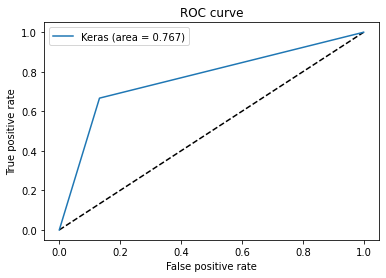

Specificity: tf.Tensor(0.8679245266642933, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.6666666638888888, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6956521708884688, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8518518502743484, shape=(), dtype=float64)


Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

In [98]:
predictor = DiabetesPredictor()
predictor.get_correlation()

Trial 26 Complete [00h 00m 01s]
val_loss: 0.5295053124427795

Best val_loss So Far: 0.4607881009578705
Total elapsed time: 00h 00m 42s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
18/18 [==============================] - 1s 24ms/step - loss: 0.5412 - auc: 0.7897 - val_loss: 0.4926 - val_auc: 0.8302
Epoch 2/50
18/18 [==============================] - 0s 2ms/step - loss: 0.4962 - auc: 0.8235 - val_loss: 0.4626 - val_auc: 0.8500
Epoch 3/50
18/18 [==============================] - 0s 2ms/step - loss: 0.4902 - auc: 0.8283 - val_loss: 0.4701 - val_auc: 0.8458
Epoch 4/50
18/18 [==============================] - 0s 2ms/step - loss: 0.4928 - auc: 0.8274 - val_loss: 0.4772 - val_auc: 0.8422
Epoch 5/50
18/18 [==============================] - 0s 2ms/step - loss: 0.4876 - auc: 0.8297 - val_loss: 0.4668 - val_auc: 0.8532
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 0.4872 - auc: 0.8267 - val_loss: 0.4695 - val_auc: 0.8431
Epoch 7/50
18/18 [============================

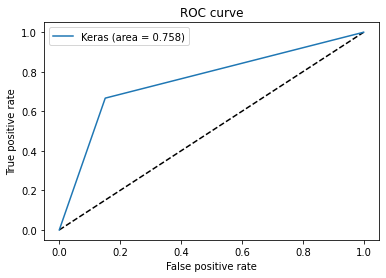

Specificity: tf.Tensor(0.8490566021715913, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.6666666638888888, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6666666638888888, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8490566021715913, shape=(), dtype=float64)
